# TDE simulations

Modification of Chang's notebook: https://github.com/desi-bgs/bgs-cmxsv/blob/main/doc/nb/validate_spectral_sims.ipynb

In [5]:
import os 
import numpy as np 
import fitsio
import sys
# add the directory where feasibgs was installed to the python path
sys.path.append(os.path.join(os.environ['HOME'], '.local/lib/python3.8/site-packages'))

# --- feasibgs --- 
from feasibgs import util as UT
from feasibgs import cmx as BGS_cmx
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import forwardmodel as FM

In [6]:
# for making pretty plots 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## Sky Brightness

You can use whichever sky brightnesses you want for the rest of the notebook. But for convenience, in this notebook we'll use preprocessed sky brightnesses from DESI CMX data. More specifically, we'll use the median sky surface brightness from sky fibers on tile 66003 and exposure 55654, which had 450s exposure time.

For details on how the CMX sky brightnesses were preprocessed see feasibgs/cmx.py

In [7]:
# function to load the preprocessed CMX sky data 
BGS_cmx.cmx_skies?

Signature: BGS_cmx.cmx_skies()
Docstring:
sky surface brightnesses from sky fibers from the CMX exposures. The
sky surface brightnesses are generated from the flat fielded sky data
that's throughput corrected. 

Return
------
skies : dictionary
    dictionary that contains data on sky fibers for a given (tile, date,
    exposure, and spectrograph). The following keys are available in the
    output dictionary: 
    - `tileid`, `date`, `mjd`, `expid`, `spectrograph`
    - observing conditions: `airmass`, `moon_ill`, `moon_alt`, `moon_sep`,
      `sun_alt`, `sun_sep`, `transparency`, `transp_min`, `transp_max`,
      `fwhm`, `exptime`
    - surface brightnesses: `sky_sb_b`, `sky_sb_r`, `sky_sb_z`,
File:      ~/.local/lib/python3.8/site-packages/feasibgs/cmx.py
Type:      function


In [8]:
def quick_coadd(waves, sbrights):
    ''' quick hack to combine wavelengths and surface brightnesses of the 3
    cameras...
    '''
    from scipy.interpolate import interp1d
    from desimodel.io import load_throughput
    # read nominal dark sky surface brightness
    wavemin = load_throughput('b').wavemin - 10.0
    wavemax = load_throughput('z').wavemax + 10.0
    outwave = np.arange(round(wavemin, 1), wavemax, 0.8) 
    
    sbrights_interp = [] 
    for wave, sbright in zip(waves, sbrights): 
        fintrp = interp1d(wave, sbright, fill_value=0., bounds_error=False) 
        sbrights_interp.append(fintrp(outwave))
    
    outsbright = np.amax(sbrights_interp, axis=0) 
    return outwave, outsbright

In [9]:
skies = BGS_cmx.cmx_skies()
cmx_exp = ((skies['tileid'] == 66003) & (skies['expid'] == 55654))

Isky = quick_coadd(
    [skies['wave_%s' % arm] for arm in ['b', 'r', 'z']], 
    [np.median(skies['sky_sb_%s' % arm], axis=0) for arm in ['b', 'r', 'z']])

In [10]:
exptime = skies['exptime'][cmx_exp][0]
airmass = np.median(skies['airmass'][cmx_exp])
print('airmass = %.2f' % airmass)
print('exposure time = %.1fs' % exptime)

airmass = 1.27
exposure time = 450.0s


(0.0, 10.0)

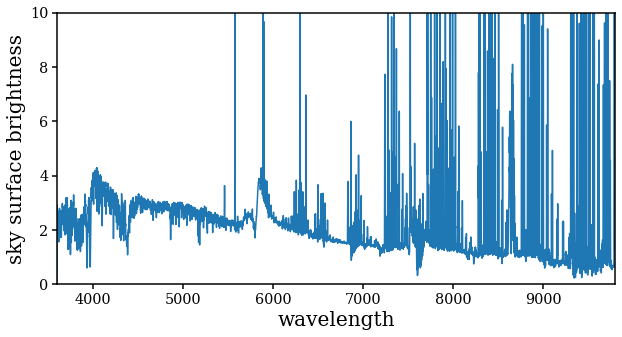

In [11]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(Isky[0], Isky[1])
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness', fontsize=20)
sub.set_ylim(0., 10)

## Generate BGS Spectral Sims for the Exposure

We've read in the sky brightness for the exposure we want to simulate. Next we'll use the BGS spectral simulation to simulate spectra for this exposure.

We begin by reading in noiseless BGS source spectra then run it through the feasibgs forward model. For details on how the BGS source spectra are constructed see feasibgs/spectral_sims.py

In [8]:
# function for reading in BGS source spectra
BGS_spec_sim.simulated_GAMA_source_spectra?

Signature: BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True)
Docstring:
read GAMA-matched fiber-magnitude scaled BGS source spectra 
These source spectra are created for GAMA objects. their spectra is 
constructed from continuum that's template matched to the broadband
colors and emission lines from GAMA data (properly flux calibrated). 
Then the spectra is scaled down to the r-band fiber magnitude. They 
therefore do not require fiber acceptance fractions. 
File:      /global/cscratch1/sd/sybenzvi/desi/conda/desitf2/lib/python3.8/site-packages/feasibgs/spectral_sims.py
Type:      function


In [38]:
# read in source wavelength, flux, and galaxy properties.
sim_lines=False
#wave_s, flux_s, prop = BGS_spec_sim.simulated_GAMA_source_spectra(emlines=sim_lines)
dirpath='/global/u2/p/palmese/desi/timedomain/tde/ZTF_TDE_2020/'
#tde = np.genfromtxt(dirpath+'tns_2019dsg_2019-05-13_08-40-46_ESO-NTT_EFOSC2-NTT_ePESSTO+.tab')
tde = np.genfromtxt(dirpath+'tns_2018lna_2019-01-26_04-26-49_P200_DBSP_ZTF.tab')
wave_s = tde[:,0]
#Sorry this is a hack for now
flux_s = np.row_stack((tde[:,1],tde[:,1]))

In [39]:
flux_s.shape

(2, 4263)

In [18]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

hx = fits.HDUList()

# Write the wavelength table.
hdu_wave = fits.PrimaryHDU(wave_s)
hdu_wave.header['EXTNAME'] = 'WAVE'
hdu_wave.header['BUNIT'] = 'Angstrom'
hdu_wave.header['AIRORVAC'] = ('vac', 'Vacuum wavelengths')
hx.append(hdu_wave)

# Write the flux table.
fluxunits = 1e-17 * u.erg / (u.s * u.cm**2 * u.Angstrom)
hdu_flux = fits.ImageHDU(flux_s)
hdu_flux.header['EXTNAME'] = 'FLUX'
hdu_flux.header['BUNIT'] = str(fluxunits)
hx.append(hdu_flux)

# Write truth properties to file.
#tabp = Table()
#for k, v in prop.items():
#    if k != 'absmag_ugriz':
#        tabp[k] = v
#    else:
#        for _mag, _v in zip('UGRIZ', v):
#            tabp[_mag + '_mag'] = _v
#hdu_prop = fits.table_to_hdu(tabp)
#hdu_prop.header['EXTNAME'] = 'TRUTH'
#hx.append(hdu_prop)

if sim_lines:
    hx.writeto('tde_spectral_template_emlines.fits', overwrite=True)
else:
    hx.writeto('tde_spectral_template_noemlines.fits', overwrite=True)

Run spectra through BGS forward model and save it to a file.

In [ ]:
fdesi = FM.fakeDESIspec()

output = 'tde_spectral_sim_emlines.fits' if sim_lines else 'tde_spectral_sim_noemlines.fits'
bgs = fdesi.simExposure(wave_s, flux_s, exptime=exptime, airmass=airmass, Isky=Isky, filename=output)

NameError: name 'bgs' is not defined

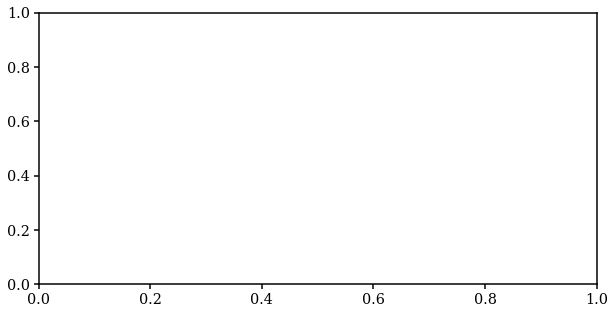

In [20]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for band in ['b', 'r', 'z']: 
    sub.plot(bgs.wave[band], bgs.flux[band][1], label={'b': 'BGS spectrum for this exposure', 'r':None, 'z':None}[band])
sub.plot(wave_s, flux_s[1], c='k', ls='--', label='Source Spectra')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-5, 10)

## Run `redrock` on spectral sims

Now that we have a simulated BGS spectra, lets run them through redrock. This will take a while. To speed it up, try running on the [Haswell or KNL cluster](https://docs.nersc.gov/systems/cori/).

In [107]:
if sim_lines:
    print('Fitting BGS spectra with em. lines.')
    !rrdesi -o redrock.bgs_spectral_sim.h5 -z zbest.bgs_spectral_sim_emlines.fits bgs_spectral_sim_emlines.fits
else:
    print('Fitting BGS spectra with no em. lines.')
    !rrdesi -o redrock.bgs_spectral_sim.h5 -z zbest.bgs_spectral_sim_noemlines.fits bgs_spectral_sim_noemlines.fits

Fitting BGS spectra with em. lines.
Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 1000 targets: 8.0 seconds
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtempla

## Calculate Redshift Success Rate

In [128]:
# read redrock output
rr_em = fitsio.read('zbest.bgs_spectral_sim_emlines.fits')
truth_em = Table.read('bgs_spectral_template_emlines.fits')

ztrue_em = truth_em['zred']
r_mag_em = truth_em['r_mag']

# redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
zsuccess_em = UT.zsuccess(rr_em['Z'], ztrue_em, rr_em['ZWARN'], deltachi2=rr_em['DELTACHI2'], min_deltachi2=40)

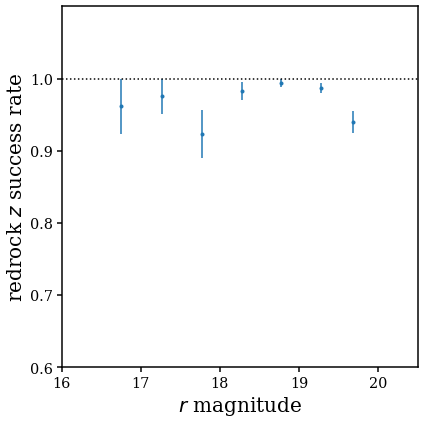

In [145]:
# calculate redshift success rate
wmean_em, rate_em, err_rate_em = UT.zsuccess_rate(r_mag_em, zsuccess_em, range=[16, 20], nbins=8, bin_min=10)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot([16, 21], [1, 1], c='k', ls=':')
sub.errorbar(wmean_em, rate_em, err_rate_em, fmt='.C0')
sub.set_xlabel('$r$ magnitude', fontsize=20)
sub.set_xlim(16, 20.5)
sub.set_ylabel('redrock $z$ success rate', fontsize=20)
sub.set_ylim(0.6, 1.1)
sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.])

fig.tight_layout();

In [146]:
# read redrock output
rr_no = fitsio.read('zbest.bgs_spectral_sim_noemlines.fits')
truth_no = Table.read('bgs_spectral_template_noemlines.fits')

ztrue_no = truth_no['zred']
r_mag_no = truth_no['r_mag']

# redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
zsuccess_no = UT.zsuccess(rr_no['Z'], ztrue_no, rr_no['ZWARN'], deltachi2=rr_no['DELTACHI2'], min_deltachi2=40)

In [ ]:
# calculate redshift success rate
wmean_no, rate_no, err_rate_no = UT.zsuccess_rate(r_mag_no, zsuccess_no, range=[16, 20], nbins=8, bin_min=10)

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot([16, 21], [1, 1], c='k', ls=':')
sub.errorbar(wmean_em, rate_em, err_rate_em, fmt='sr', label='em. lines')
sub.errorbar(wmean_no, rate_no, err_rate_no, fmt='sC0', label='no em. lines')
sub.set_xlabel('$r$ magnitude', fontsize=20)
sub.set_xlim(16.5, 20.)
sub.set_ylabel('redrock $z$ success rate', fontsize=20)
sub.set_ylim(0.6, 1.1)
sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.])

sub.legend(ncol=2, loc='best', fontsize=12)

fig.tight_layout();

In [137]:
UT.zsuccess_rate?

Signature: UT.zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2)
Docstring:
measure the redshift success rate along with property `prop`

:params prop: 
    array of properties (i.e. Legacy r-band magnitude) 

:params zsuccess_cond:
    boolean array indicating redshift success 

:params range: (default: None) 
    range of the `prop` 

:params nbins: (default: 20) 
    number of bins to divide `prop` by 

:params bin_min: (default: 2)  
    minimum number of objects in bin to exlcude it 

:return wmean: 
    weighted mean of `prop` in the bins 

:return e1: 
    redshift success rate in the bins

:return ee1: 
    simple poisson error on the success rate
File:      /global/cscratch1/sd/sybenzvi/desi/conda/desitf2/lib/python3.8/site-packages/feasibgs/util.py
Type:      function


In [ ]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)

    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate